In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import seaborn as sns
from scipy.stats import zscore
import optuna
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

c:\Users\Administrator\Desktop\FinetuningOptuna\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

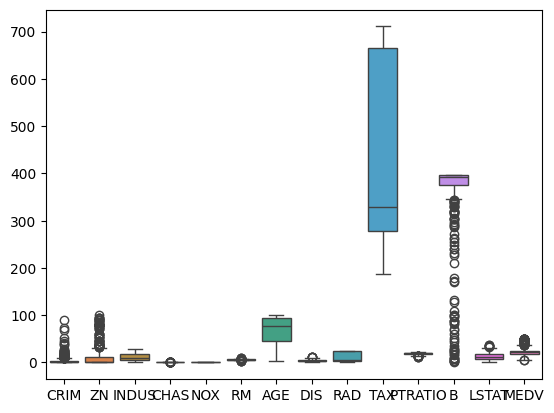

In [3]:
data = pd.read_csv("C:/Users/Administrator/Desktop/FinetuningOptuna/boston.csv")
sns.boxplot(data)

c:\Users\Administrator\Desktop\FinetuningOptuna\venv\lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


<Axes: >

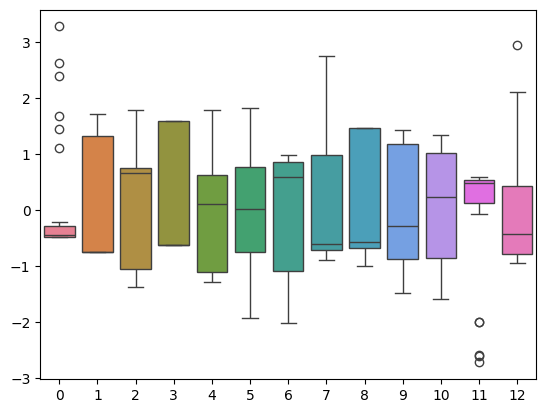

In [4]:
out = IForest(contamination=0.1)
out_pred = out.fit_predict(data)
std_data = data[out_pred == 1]
X = std_data.drop("MEDV", axis = 1)
y = std_data["MEDV"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
sns.boxplot(X_train_scaled)


In [5]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
r2_score(y_test, y_pred)
mean_absolute_error(y_test, y_pred)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


0.7799699180556394

5.141252709515538

In [6]:
def objective(trial):
    hiper = {
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "copy_X": trial.suggest_categorical("copy_X", [True, False]),
        "positive": trial.suggest_categorical("positive", [True, False]),
        "n_jobs" : -1
    }
    model = LinearRegression(**hiper)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = r2_score(y_test, y_pred)
    return acc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_jobs=-1, n_trials=1000)

[I 2025-08-24 21:00:09,196] A new study created in memory with name: no-name-5f4be7c0-4ec5-4dc9-b899-9ce72eb09c5f
[I 2025-08-24 21:00:09,203] Trial 0 finished with value: 0.7799699180556394 and parameters: {'fit_intercept': True, 'copy_X': True, 'positive': False}. Best is trial 0 with value: 0.7799699180556394.
[I 2025-08-24 21:00:09,210] Trial 1 finished with value: 0.522562947081415 and parameters: {'fit_intercept': True, 'copy_X': False, 'positive': True}. Best is trial 0 with value: 0.7799699180556394.
[I 2025-08-24 21:00:09,216] Trial 3 finished with value: -3.421940333988432 and parameters: {'fit_intercept': False, 'copy_X': True, 'positive': False}. Best is trial 0 with value: 0.7799699180556394.
[I 2025-08-24 21:00:09,225] Trial 4 finished with value: 0.7799699180556394 and parameters: {'fit_intercept': True, 'copy_X': True, 'positive': False}. Best is trial 0 with value: 0.7799699180556394.
[I 2025-08-24 21:00:09,227] Trial 5 finished with value: 0.5225629470814148 and parame

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


0.7799699180556393

5.141252709515543

<Axes: xlabel='MEDV'>

Text(0.5, 0, 'Y_true')

Text(0, 0.5, 'Y_pred')

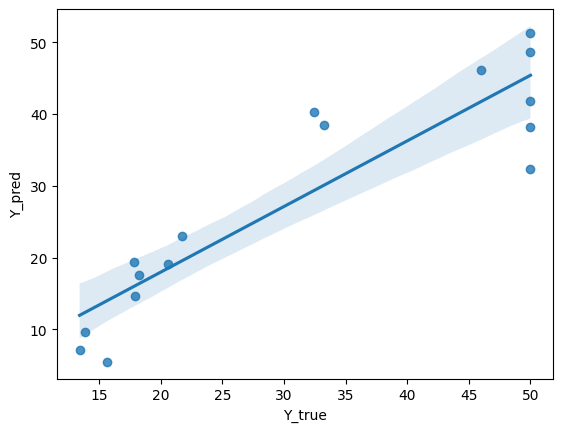

In [7]:
model = LinearRegression(**study.best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
r2_score(y_test, y_pred)
mean_absolute_error(y_test, y_pred)

sns.regplot(x=y_test, y=y_pred)
plt.xlabel("Y_true")
plt.ylabel("Y_pred")